<a href="https://colab.research.google.com/github/abhijeet-sarkar-01/autism_detection/blob/main/updatedKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Install necessary packages
!pip install nilearn

# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.datasets import fetch_abide_pcp
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Fetch data from ABIDE for NYU and UM_1 sites
data = fetch_abide_pcp(derivatives=['rois_aal'], SITE_ID=['NYU', 'UM_1'])


[get_dataset_dir] Dataset found in /root/nilearn_data/ABIDE_pcp

Feature shape: (258, 6786)
Label distribution: [150 108]
Fitting 6 folds for each of 480 candidates, totalling 2880 fits

--- Test Set Performance ---
Best Parameters: {'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 100}
Accuracy:  0.6154
Precision: 0.6667
Recall:    0.1818
F1 Score:  0.2857


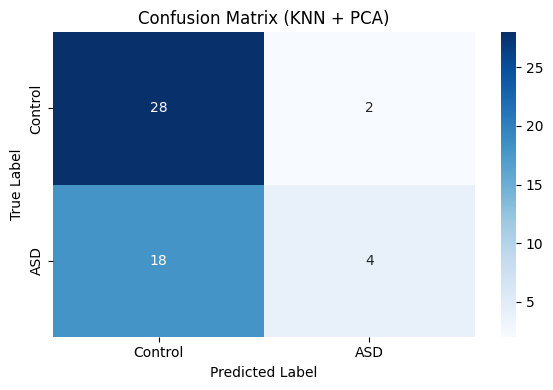


Cross-Validation Accuracy (entire dataset): 0.6126


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

conn_est = ConnectivityMeasure(kind='correlation')
conn_matrices = conn_est.fit_transform(data['rois_aal'])
X = sym_matrix_to_vec(conn_matrices)

# Labels: ASD=1, Control=0
y = data.phenotypic['DX_GROUP'].values
y[y == 2] = 0

print("Feature shape:", X.shape)
print("Label distribution:", np.bincount(y))  # [Controls, ASD]

# -----------------------------------
# 2. Train/test split
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------
# 3. Pipeline: Scaling → PCA → KNN
# -----------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for tuning
param_grid = {
    'pca__n_components': [10, 20, 30, 50, 100, 150],
    'knn__n_neighbors': list(range(1, 21)),
    'knn__p': [1, 2],  # 1: Manhattan, 2: Euclidean
    'knn__weights': ['uniform', 'distance']
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    pipeline, param_grid, cv=6, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# -----------------------------------
# 4. Evaluation
# -----------------------------------
print("\n--- Test Set Performance ---")
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (KNN + PCA)')
plt.tight_layout()
plt.show()

# -----------------------------------
# 5. Cross-Validation Accuracy
# -----------------------------------
cv_results = cross_validate(best_model, X, y, cv=5, scoring='accuracy')
cv_acc = np.mean(cv_results['test_score'])
print(f"\nCross-Validation Accuracy (entire dataset): {cv_acc:.4f}")